# Using scanCONTROL with Python 3

This notebook shows how to use the MICRO-EPSILON scanCONTROL laser line triangulators with in a Python environment. The Python version used to write the DLL wrapper and the examples is 3.5.

Let's get into it:
The LLT.dll is the main library to use the scanner in a Windows system environment. This C library is wrapped via ctypes in the module pyllt. To interface the DLL in our application we have to declare C variables, which is possible with C types.

So we import the modules pyllt and ctypes:

In [1]:
import pyllt as llt
import ctypes as ct

The DLL internally works with device handles for each scanner instance. For every scanner a seperate handle has to be created. For this use the function CreateLLTDevice(TInterfaceType interface). In our case the scanner is connected via Ethernet.

In [2]:
hLLT = llt.create_llt_device(llt.TInterfaceType.INTF_TYPE_ETHERNET)

Now we can search the interface for devices. In the case of an Ethernet interface, the IP addresses are written into the array which was given to the function. Then we can assign a specific interface to a certain handle.

In [3]:
available_interfaces = (ct.c_uint*6)()

llt.get_device_interfaces_fast(hLLT, available_interfaces, len(available_interfaces))
llt.set_device_interface(hLLT, available_interfaces[0], 0)

1

The time has come to connect to the sensor!

In [4]:
llt.connect(hLLT)

1

Let's see which sensor we've got here.

In [5]:
scanner_type = ct.c_int(0)

llt.get_llt_type(hLLT, ct.byref(scanner_type))

1

Check which resolutions are supported and set the highest one.

In [6]:
available_resolutions = (ct.c_uint*4)()

llt.get_resolutions(hLLT, available_resolutions, len(available_resolutions))

resolution = available_resolutions[0]

llt.set_resolution(hLLT, resolution)

1

Set the profile configuration to the stan

In [7]:
llt.set_profile_config(hLLT, llt.TProfileConfig.PROFILE)

1

Start transfering profiles

In [8]:
llt.transfer_profiles(hLLT, llt.TTransferProfileType.NORMAL_TRANSFER, 1)

65536

Allocate correctly sized buffer array and fetch the lastest received profile raw data from the internal receiving buffer.

In [9]:
profile_buffer = (ct.c_ubyte*(resolution*64))()
lost_profiles = ct.c_int()

llt.get_actual_profile(hLLT, profile_buffer, len(profile_buffer), llt.TProfileConfig.PROFILE, ct.byref(lost_profiles))

65536

Stop transfering profiles.

In [10]:
# llt.transfer_profiles(hLLT, TTransferProfileType.NORMAL_TRANSFER, 0)
llt.transfer_profiles(hLLT, 0, 0)

1

In [11]:
x = (ct.c_double * resolution)()
z = (ct.c_double * resolution)()
intensities = (ct.c_ushort * resolution)()

snull = ct.POINTER(ct.c_ushort)()
inull = ct.POINTER(ct.c_uint)()

llt.convert_profile_2_values(hLLT, profile_buffer, resolution, llt.TProfileConfig.PROFILE, scanner_type, 0, 1,
                                    snull, intensities, snull, x, z, inull, inull)

6656

Disconnect the sensor from the application.

In [12]:
llt.disconnect(hLLT)

1

Plot profile and intensities of received profile.

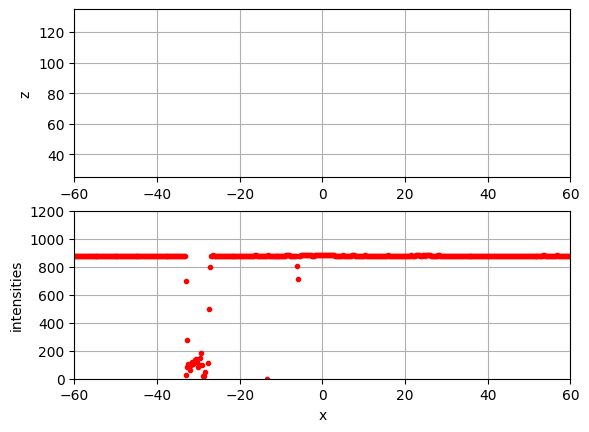

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(facecolor='white')
plt.subplot(211)
plt.grid()
plt.ylabel('z')
plt.xlim(-60, 60)
plt.ylim(25, 135)
plt.plot(x, z, 'g.', label="z", lw=1)
plt.subplot(212)
plt.grid()
plt.xlabel('x')
plt.ylabel('intensities')
plt.xlim(-60, 60)
plt.ylim(0, 1200)
plt.plot(x, intensities, 'r.', label="intensities", lw=1)
plt.show()

FIN!